# Introduction to Deep Emulators
## Or, how to bring chaos to chaos
##### Or, how to solve the three-body problem through sheer hubris

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import tqdm
from sklearn.preprocessing import StandardScaler
torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
np.random.seed(0)

### Let's do a physics simulation.

We'll set up a kinetic simulation, where several particles are tracked individually. In principle we can have any number of particles in the simulation; some particle-in-cell codes are run with over 10<sup>5</sup> particles (or macroparticles), and somehow people are fine with how expensive that gets. But let's just stick to a few. We want this to run very quickly on a laptop, so we'll choose as few particles as possible while still having enough to make a kinetic solution analytically intractable.

First, we need our initial conditions. We'll define three classes of particles in our little universe.
- One class we'll call "charges". For simplicity, all charges have the same inertia, but the values of their charges (whether that be electrostatic charge, gravitational charge, etc; this quantity governs the strength of their pairwise interaction) can have any value, even negative values. Not all charges have to have the same strength.
- The second class we'll call "potentials". These are exactly like charges, but they have infinite inertia: they are fixed in place. You can think of potentials as sources of a background field interacting with the other particles.
- Though we won't use them extensively in this notebook, we'll also define a third class called "test particles". These are exactly like charges, including having the same inertia, except they only feel forces from the other types of particles, and do not exert any force of their own. This is a bit unphysical (in the real-life universe anyway), but one could treat these particles as ones with infinitesimal charge values of their own. Later on we'll not include these in the notebook, but the code is in place to do so if you want to change things around.

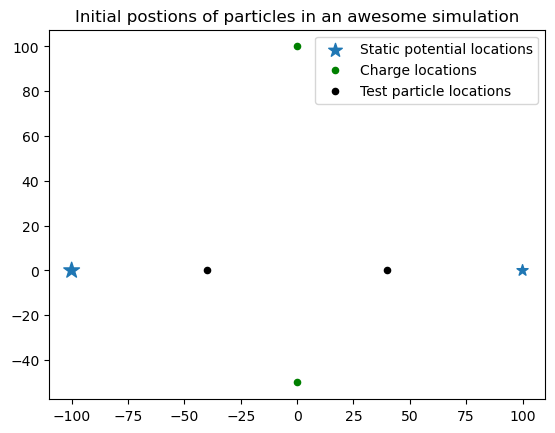

In [2]:
potential_locs = [[-100, 0], [100, 0]]
potential_qs = [10, 5]

init_charge_locs = [[0, 100], [0, -50]]
init_charge_vs = [[0, 0], [0, 0]]
charge_qs = [5, 5]

init_test_locs = [[-40, 0], [40, 0]]
init_test_vs = [[0, 0], [0, 0]]
test_qs = [1, 1]  # This is relevant only for symmetric forces like those used here, where F on q depends on the value of q


plt.scatter([coords[0] for coords in potential_locs], [coords[1] for coords in potential_locs], s=14*np.array(potential_qs), 
            marker="*", label="Static potential locations")
plt.scatter([coords[0] for coords in init_charge_locs], [coords[1] for coords in init_charge_locs], s=20, c="green",
           label="Charge locations")
plt.scatter([coords[0] for coords in init_test_locs], [coords[1] for coords in init_test_locs], s=20, c="black",
           label="Test particle locations")
plt.title("Initial postions of particles in an awesome simulation")
plt.legend()

### Now we do a traditional n-body simulation

No need to pay too much attention to the mechanics of how things work in the cell below. The long and short of it (really, just the short of it) we let the particles as described above evolve according inverse-square force of the form F=qQ/r<sup>2</sup>, where q and Q are the charges and r is the displacement between them.

In [3]:
class Simulator:
    def __init__(self):
        # Initialize the phase-space trajectories to the initial positions defined by the global variables in the cell above.
        self.reset(init_charge_locs, init_charge_vs, init_test_locs, init_test_vs)
        
    def reset(self, charge_locs, charge_vs, test_locs, test_vs):
        """
        Re-initialize the lists which contain the trajectory and velocity-space trajectory of each particle.
        When called, the lists revert to containing one element each, given by the arguments to this method.
        """
        self.charge_trajectories = [charge_locs]
        self.charge_v_trajectories = [charge_vs]
        self.test_trajectories = [test_locs]
        self.test_v_trajectories = [test_vs]
        
    def find_distances(self, this_loc, forcers_locs):
        """
        Calculate the displacements and directions between a single particle with location `this_loc` and a set of other
        particles of one species, the forcers, with locations `forcers_locs`.
        """
        num_forcers = len(forcers_locs)
        distances = np.zeros(num_forcers)
        direction_vectors = np.zeros((len(forcers_locs), 2))

        for i in range(num_forcers):
            distances[i] = np.sqrt((forcers_locs[i][0]-this_loc[0])**2 + (forcers_locs[i][1]-this_loc[1])**2)
            direction_vectors[i] = np.array([forcers_locs[i][0]-this_loc[0], forcers_locs[i][1]-this_loc[1]])/distances[i]

        return distances, direction_vectors

    def physics_step(self, locs, vs, qs):
        """
        Steps the locs and velocities for a single species of particle (either charges or tests) forward by a single delta t.
        """
        # for each particle, determine distance to all potentials and charges
        forces = np.zeros((len(locs), 2*(len(locs) > 0)))
        # The conditional is used to make this size 0 if we pass an empty list for the coordinates of the species' particles
        for particle_num in range(len(locs)):
            distances_to_potentials, directions_to_potentials = self.find_distances(locs[particle_num], potential_locs)
            distances_to_charges, directions_to_charges = self.find_distances(locs[particle_num], self.charge_trajectories[-1])
            # The distance between a particle and itself is zero, so we use nansum to ignore those contributions to the force on a particle
            forces[particle_num][0] += np.nansum(np.float64(qs[particle_num]) * np.array(potential_qs, dtype="float") * directions_to_potentials[:, 0] / distances_to_potentials)
            forces[particle_num][1] += np.nansum(np.float64(qs[particle_num]) * np.array(potential_qs, dtype="float") * directions_to_potentials[:, 1] / distances_to_potentials)
            forces[particle_num][0] += np.nansum(np.float64(qs[particle_num]) * np.array(charge_qs, dtype="float") * directions_to_charges[:, 0] / distances_to_charges)
            forces[particle_num][1] += np.nansum(np.float64(qs[particle_num]) * np.array(charge_qs, dtype="float") * directions_to_charges[:, 1] / distances_to_charges)

        new_vs = vs + forces
        new_locs = locs + new_vs

        return new_locs, new_vs
    
    def run(self, timesteps, disable_tqdm=False):
        """
        Applies physics_step() a bunch of times and updates the locations an velocities of each species based on
        the forces.
        """
        for timestep in tqdm.trange(timesteps, disable=disable_tqdm):
            # Test particles must be updated first so they accurately reflect influence from the charges' current positions
            new_test_locs, new_test_vs = self.physics_step(self.test_trajectories[-1], self.test_v_trajectories[-1], test_qs)
            new_charge_locs, new_charge_vs = self.physics_step(self.charge_trajectories[-1], self.charge_v_trajectories[-1], charge_qs)
            self.charge_trajectories.append(new_charge_locs)
            self.charge_v_trajectories.append(new_charge_vs)
            self.test_trajectories.append(new_test_locs)
            self.test_v_trajectories.append(new_test_vs)
            
        
    def plot_trajectories(self):
        for charge_num in range(len(self.charge_trajectories[0])):
            plt.plot([timestep[charge_num][0] for timestep in self.charge_trajectories],
                    [timestep[charge_num][1] for timestep in self.charge_trajectories],
                    c="green")
        for test_num in range(len(self.test_trajectories[0])):
            plt.plot([timestep[test_num][0] for timestep in self.test_trajectories],
                    [timestep[test_num][1] for timestep in self.test_trajectories],
                    c="black")
        # indicate particles' current positions
        plt.scatter([coords[0] for coords in potential_locs], [coords[1] for coords in potential_locs], s=14*np.array(potential_qs), marker="*")
        plt.scatter([coords[0] for coords in self.charge_trajectories[-1]], [coords[1] for coords in self.charge_trajectories[-1]], s=20, c="green")
        plt.scatter([coords[0] for coords in self.test_trajectories[-1]], [coords[1] for coords in self.test_trajectories[-1]], s=20, c="black")  
        

    def plot_trajectories_subplots(self, ax):
        """
        Same as plot_trajectories but for when you need to put the plot in a specific subplots axis.
        """
        for charge_num in range(len(self.charge_trajectories[0])):
            ax.plot([timestep[charge_num][0] for timestep in self.charge_trajectories],
                    [timestep[charge_num][1] for timestep in self.charge_trajectories],
                    c="green")
        for test_num in range(len(self.test_trajectories[0])):
            ax.plot([timestep[test_num][0] for timestep in self.test_trajectories],
                    [timestep[test_num][1] for timestep in self.test_trajectories],
                    c="black")
        # indicate particles' current positions
        ax.scatter([coords[0] for coords in potential_locs], [coords[1] for coords in potential_locs], s=14*np.array(potential_qs), marker="*")
        ax.scatter([coords[0] for coords in self.charge_trajectories[-1]], [coords[1] for coords in self.charge_trajectories[-1]], s=20, c="green")
        ax.scatter([coords[0] for coords in self.test_trajectories[-1]], [coords[1] for coords in self.test_trajectories[-1]], s=20, c="black")  

### Great, given the initial conditions, let's run our simulation for a whole bunch of timesteps!

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\Raman\AppData\Local\Temp\ipykernel_179508\2463350133.py:27: RuntimeWarning: invalid value encountered in divide
  direction_vectors[i] = np.array([forcers_locs[i][0]-this_loc[0], forcers_locs[i][1]-this_loc[1]])/distances[i]
100%|██████████| 50/50 [00:00<00:00, 3010.55it/s]


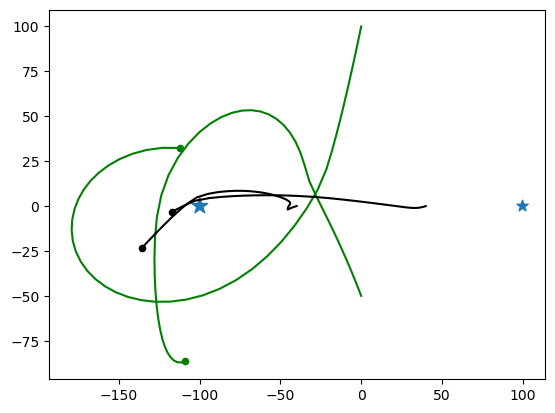

In [4]:
simulator = Simulator()
simulator.run(50)
simulator.plot_trajectories()

### Ooooh...ahhhh...orbits!
This looks pretty good. The particles are drawn to the largest attractor, and clearly perturb each others' trajectories along the way.

### There's just one problem...
Even though we seem to be reproducing real-world physics very precisely, you can imagine how this type of simulation would become quickly expensive with larger simulation periods ( O(n) ), more phase space dimensions (I think O(n) ) and especially with larger number of particles ( O(n<sup>2</sup>) ). If a physicist is too greedy with how much resolution they want, even the most powerful supercomputers won't be able to handle their kinetic simulations.

Here are some numbers...
- You want to resolve at least a few interaction lengths (e.g. Debye lengths) and interaction periods (e.g. gyroperiods).
- With this in mind, science-grade prototype (i.e. not production-line, CCMC stuff) PICs simulating 10<sup>7</sup> particles for 10<sup>6</sup> timesteps can take around 8 node-hours on a Cray built in the 2020s!
- This scale of number of particles is necessary. Phenomenology-to-noise ratio scales with N<sup>1/4</sup>.
- One of the most famous production-quality space plasma simulators, [https://www.helsinki.fi/en/researchgroups/vlasiator](Vlasiator), is so expensive that it only has been run a few times in its entirety (6D ion phase space + 6D electron fluid phase space, full magnetosphere)...and it's not even fully kinetic! A full run of Vlasiator takes **months** on **~10,000** cores!
- One of the most famous production-quality fusion plasma simulators, [https://genecode.org/](GENE), has done some groundwork for ITER also using about 10<sup>8</sup> core-hours.

As you might have expected, the solution is...drum roll...machine learning! Basically, the idea is this: we run the simulation a few times (a necessary sacrifice), and train an ML model on those runs. Then, rather than racking up a gargantuan electric bill by continuing to run the simulation, we can plug the initial conditions into the ML model and get *its* outputs instead.

In theory, this could work very well. The physics model is just the application of a function to the initial conditions, and the Universal Approximation Theorem tells us that any function can be approximated with arbitrary accuracy by a sufficiently well-trained neural network. Of course, I'm not sufficiently good at training neural networks, but let's just ignore that for now, thanks.

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, batch_size=8):
        super().__init__()
        
        # Nothing fancy here.
        self.fc1 = nn.Linear(batch_size, 50).float()  # Have to convert to float because for some reason this ignores set_default_dtype(torch.float64)
        self.act1 = nn.ReLU().float()
        self.fc2 = nn.Linear(50, 50).float()
        self.act2 = nn.ReLU().float()
        self.output = nn.Linear(50, 8).float()

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.output(x)
        return x

Above we have a very simple neural network, to keep things easy on us and to have something to blame when we don't get the results we want.

Let's also define a loss function which measures the distance between two microstates. This isn't exactly the standard euclidean distance in the 4D phase space because position has no relationship to velocity. Instead, we measure how far apart a particle is from its counterpart in another microstate, and then add to it how far apart it is in velocity space from the same particle.

We could use this as the loss function for our neural network. I won't do it here (but you can if you care to modify the code), though we will be using it to judge how well the trained model does on validation cases.

In [6]:
def quadrature_loss(outputs, targets, include_v=False):
    length = len(outputs)
    targets = torch.tensor(targets)
    output_x, output_y = outputs[0:length//2:2], outputs[1:length//2:2]
    output_vx, output_vy = outputs[length//2::2], outputs[length//2+1::2]
    target_x, target_y = targets[0:length//2:2], targets[1:length//2:2]
    target_vx, target_vy = targets[length//2::2], targets[length//2+1::2]
    return torch.mean(torch.sqrt((target_x-output_x)**2 + (target_y-output_y)**2)) +\
        include_v * torch.mean(torch.sqrt((target_vx-output_vx)**2 + (target_vy-output_vy)**2))

### Creating the training set

#### Input data

We create our input data by setting the initial conditions to uniformly-distributed random states. The input tensor is a set of vectors with the form (particle_1_x, particle_1_y,...,particle_n_x, particle_n_y, particle_1_vx, particle_1_vy,...,particle_n_vx, particle_n_vy)

The random values are done with replacement here. It doesn't matter much in this case, but you should really not do this in order to avoid biasing the model. Each set of initial conditions should be at least a little unique.

In [7]:
num_samples = 1000
all_charge_locs, all_charge_vs, all_initial_conditions = [], [], []
for initial_condition in range(num_samples):
    random_charge_locs = np.random.randint(-100, 100, size=(2, 2))
    random_charge_vs = np.random.randint(-10, 10, size=(2, 2)) 
    all_charge_locs.append(random_charge_locs)
    all_charge_vs.append(random_charge_vs)
    all_initial_conditions.append(np.append(np.ravel(random_charge_locs), np.ravel(random_charge_vs)))
print(all_charge_locs[:2],'\n', all_charge_vs[:2])
all_initial_conditions = np.array(all_initial_conditions)
print(all_initial_conditions[:2])
# Let's ignore test particles for now
init_test_locs, init_test_vs, test_qs = [], [], []

[array([[ 72, -53],
       [ 17,  92]]), array([[-79, -64],
       [-13, -30]])] 
 [array([[-7, -7],
       [-3, -1]]), array([[ 2, -9],
       [-4, -3]])]
[[ 72 -53  17  92  -7  -7  -3  -1]
 [-79 -64 -13 -30   2  -9  -4  -3]]


#### Target data
Now we get our target data by running the simulation once for each set of initial conditions, and grabbing the final state of each run. The target vectors are in the same form as the input vectors.

In [8]:
simulator = Simulator()
all_final_states = []
for sample in tqdm.trange(num_samples):
    simulator.reset(all_charge_locs[sample], all_charge_vs[sample], init_test_locs, init_test_vs)
    simulator.run(10, disable_tqdm=True)
    end_charge_locs = simulator.charge_trajectories[-1].ravel()  # ravel() is a row-major operation
    end_charge_vs = simulator.charge_v_trajectories[-1].ravel()
    all_final_states.append(np.append(end_charge_locs, end_charge_vs))
print(all_final_states[:4])

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\Raman\AppData\Local\Temp\ipykernel_179508\2463350133.py:27: RuntimeWarning: invalid value encountered in divide
  direction_vectors[i] = np.array([forcers_locs[i][0]-this_loc[0], forcers_locs[i][1]-this_loc[1]])/distances[i]
100%|██████████| 1000/1000 [00:01<00:00, 581.16it/s]

[array([ -5.86470291, -93.49434576, -18.6352618 ,  53.85159631,
        -8.47273911,  -1.72940844,  -4.23061618,  -6.15027757]), array([-5.06910387e+01, -1.04571247e+02, -8.41642549e+01, -5.51851461e+01,
        2.75993716e+00,  9.00267209e-02, -8.79578177e+00, -1.67977985e+00]), array([-71.28747066,  65.24441766, -55.84813676,  -5.20858843,
        -6.37811587,  -4.48699429,  -7.13888373,   3.4150672 ]), array([128.72803978, -77.39827888, 129.97496618, -45.98023764,
         9.92665913,  -5.97278981,  -1.26224232,  -1.59085423])]


In [9]:
# Train-validation split
train_set_size = 9 * num_samples // 10
train_initial_conditions = all_initial_conditions[:train_set_size]
train_final_states = all_final_states[:train_set_size]
valid_initial_conditions = all_initial_conditions[train_set_size:]
valid_final_states = all_final_states[train_set_size:]
valid_initial_locs = all_charge_locs[train_set_size:]
valid_initial_vs = all_charge_vs[train_set_size:]

In [10]:
scaler = StandardScaler()
scaled_initial_conditions = torch.from_numpy(scaler.fit_transform(np.array(train_initial_conditions)))  # Scale the input data
training_dataset = TensorDataset(scaled_initial_conditions.float(), torch.FloatTensor(np.array(train_final_states))) # Create an object to represent our training dataset...
train_loader = DataLoader(training_dataset, num_workers=0)  # ...and a dataloader to handle it

### With all the data wrangling out the way, it's finally time to train the emulator!

In [11]:
def train_model(model, train_loader, loss_fn, num_epochs=200):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()  # Put the model in training mode
    for epoch in tqdm.trange(num_epochs, desc="Training model. Epoch"):
        for step_num, datum in enumerate(train_loader):  # Objects in a dataloader must be accessed this way
            inputs, targets = datum  # Inputs = initial conditions, targets = final conditions
            optimizer.zero_grad()  # Reset the gradients so they don't accumulate over successive backpropagations
            outputs = model(inputs)  # Good ol' forward pass
            loss = loss_fn(outputs, targets)  # Calculate the loss between predicted data and ground truth
            loss.backward()  # Use loss to update weights
            optimizer.step()  # Update the stochastic gradient descent optimizer

In [12]:
# Instantiate and train the model
torch.manual_seed(0)  # We really have to set this up every time? I hope I didn't miss one of these
Predictor = NeuralNetwork()
loss_fn = nn.MSELoss() # Loss function for training. I don't really feel motivation to implement test loss.
# Psst -- try replacing nn.MSELoss() with quadrature_loss and see what happens!
train_model(Predictor, train_loader, loss_fn)

Training model. Epoch: 100%|██████████| 200/200 [04:19<00:00,  1.30s/it]


In [13]:
# Do inference on the validation set
valid_initial_conditions_scaled = torch.from_numpy(scaler.transform(np.array(valid_initial_conditions))).float()  # Scale validation input data
Predictor.eval()
with torch.no_grad():  # Get the output of the model without calculating gradients, i.e. do inference
    predictions = Predictor(valid_initial_conditions_scaled)

## Model validation

Now that we have a trained model, let's <span style="color:green">run the simulation</span> on a bunch of different initial conditions. For each one, we'll compare it to the <span style="color:orange">predicted final state using the neural network</span>. This way, we'll see how the model performs at predicting ~~several different validation cases~~ all possible outcomes.

![all_possible_outcomes](all_possible_outcomes.gif "all_possible_outcomes")

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Raman\AppData\Local\Temp\ipykernel_179508\2463350133.py:27: RuntimeWarning: invalid value encountered in divide
  direction_vectors[i] = np.array([forcers_locs[i][0]-this_loc[0], forcers_locs[i][1]-this_loc[1]])/distances[i]
100%|██████████| 10/10 [00:00<00:00, 2102.62it/s]


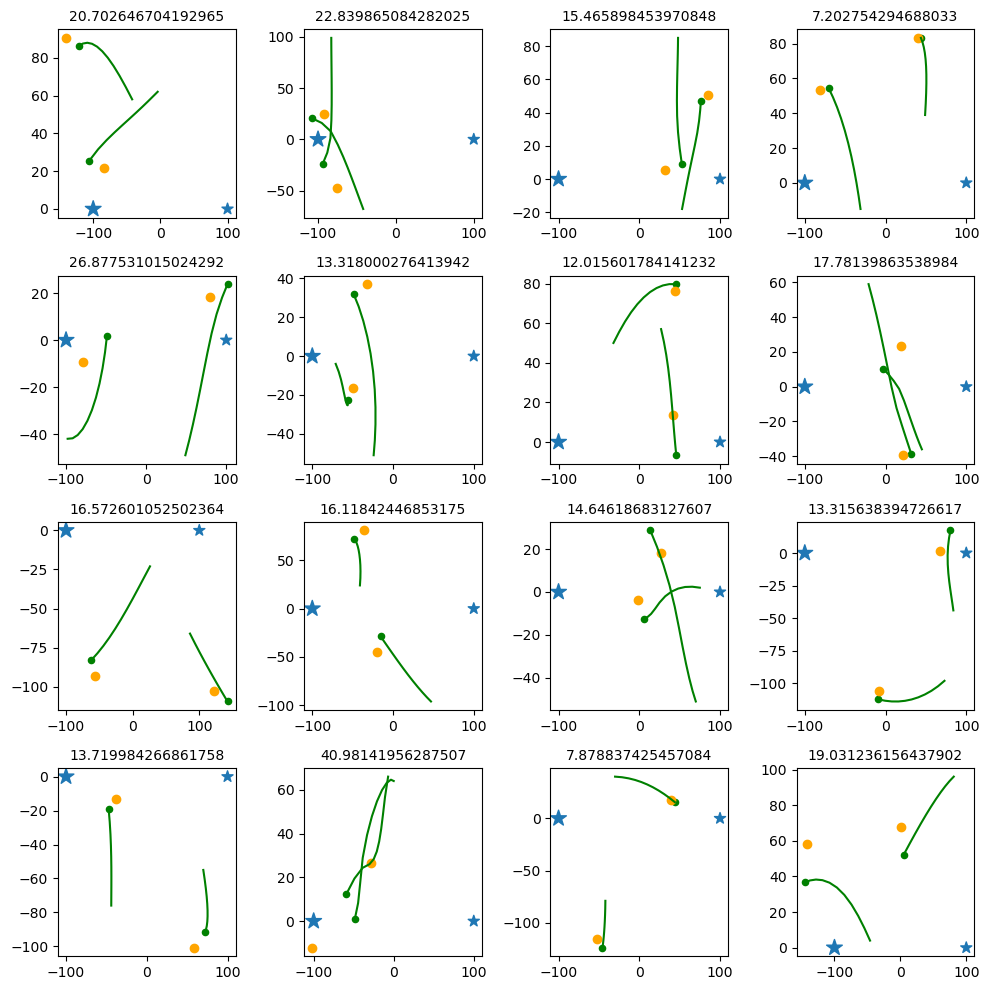

In [14]:
simulator = Simulator()
fig, axs = plt.subplots(4,4)
fig.set_size_inches(10, 10)
for row in range(4):
    for column in range(4):
        trial_num = 4*row+column
        simulator.reset(valid_initial_locs[trial_num], valid_initial_vs[trial_num], init_test_locs, init_test_vs)
        simulator.run(10)
        simulator.plot_trajectories_subplots(axs[row, column])
        axs[row, column].scatter(predictions[trial_num][0:len(predictions[0])//2:2], predictions[trial_num][1:len(predictions[0])//2:2], color="orange")
        axs[row, column].set_title(quadrature_loss(predictions[trial_num], valid_final_states[trial_num]).numpy(), fontsize=10)
plt.tight_layout()

In [15]:
print("The distance-only (i.e. not including velocity) quadrature loss, averaged over each trial and each particle, is:\n", np.mean([quadrature_loss(predictions[trial_num], valid_final_states[trial_num]).numpy() for trial_num in range(len(predictions))]))

The distance-only (i.e. not including velocity) quadrature loss, averaged over each trial and each particle, is:
 16.93497353743982


So we can actually get some pretty good predictions, given that the system is fully chaotic (in the technical sense)! But of course, it's not perfect.

## What if the model focuses on learning the physics step, instead of trying to guess the end state from the initial conditions?

This seems a bit more intuitive because the neural network now has less on its plate at once. It should also learn something representative of what we consider to be the proper formulation of the relevant physics, so this approach is more amenable to things like physics-informed loss functions. It should *also* give us entire emulated trajectories, so we're not just comparing the final states when we validate the model!

In [16]:
from scipy.ndimage import shift
# Reduce the number of samples so training is faster
num_samples = 100  # A 10x reduction and 10 timesteps per trial means we actually have the same amount of training data 

simulator = Simulator()
x, y = [], []
for sample in tqdm.trange(num_samples):
    simulator.reset(all_charge_locs[sample], all_charge_vs[sample], init_test_locs, init_test_vs)
    simulator.run(10, disable_tqdm=True)
    this_trajectories = [point.ravel() for point in simulator.charge_trajectories]
    this_v_trajectories = [point.ravel() for point in simulator.charge_v_trajectories]
    locs_one_step_ahead = shift(this_trajectories, (-1, 0), cval=np.NaN)
    vs_one_step_ahead = shift(this_v_trajectories, (-1, 0), cval=np.NaN)
    # Make the array and the shifted array the same length
    locs_one_step_ahead = locs_one_step_ahead[:-1]
    vs_one_step_ahead = vs_one_step_ahead[:-1]
    this_trajectories = this_trajectories[:-1]
    this_v_trajectories = this_v_trajectories[:-1]

    x.append(np.concatenate((this_trajectories, this_v_trajectories), axis=1))
    y.append(np.concatenate((locs_one_step_ahead, vs_one_step_ahead), axis=1))
x = np.concatenate(x, axis=0)
y = np.concatenate(y, axis=0)

print(x.shape, y.shape)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Raman\AppData\Local\Temp\ipykernel_179508\2463350133.py:27: RuntimeWarning: invalid value encountered in divide
  direction_vectors[i] = np.array([forcers_locs[i][0]-this_loc[0], forcers_locs[i][1]-this_loc[1]])/distances[i]
100%|██████████| 100/100 [00:00<00:00, 519.18it/s]

(1000, 8) (1000, 8)


In [17]:
# Train-validation split
assert len(x) == len(y)
train_set_size = 9 * len(x) // 10
train_x = x[:train_set_size]
train_y = y[:train_set_size]
valid_x = x[train_set_size:]
valid_y = y[train_set_size:]

In [18]:
# Prepare training data
scaler = StandardScaler()
x_scaled = torch.from_numpy(scaler.fit_transform(train_x))  # Scale the input data
training_dataset = TensorDataset(x_scaled.float(), torch.FloatTensor(train_y))
train_loader = DataLoader(training_dataset, shuffle=True, num_workers=0)  # Now we have to shuffle the training data because we generated it in order

In [19]:
# Instantiate and train the model
torch.manual_seed(0)  # We really have to set this up every time? I hope I didn't miss one of these
Predictor = NeuralNetwork()
loss_fn = nn.MSELoss() # Loss function for training. I don't really feel motivation to implement test loss
train_model(Predictor, train_loader, loss_fn)

Training model. Epoch: 100%|██████████| 200/200 [04:08<00:00,  1.24s/it]


In [20]:
# Do inference on the validation set
valid_x_scaled = torch.from_numpy(scaler.transform(np.array(valid_x))).float()  # Scale validation input data
Predictor.eval()
with torch.no_grad():  # Get the output of the model without calculating gradients, i.e. do inference
    predictions = Predictor(valid_x_scaled)

In [21]:
np.shape(predictions)

torch.Size([100, 8])

In [22]:
def emulate_run(charge_locs, charge_vs, timesteps):
    """
    Given a set of initial conditions, this function uses a trained model to emulate an entire simulation run by iteratively
    applying the model.
    """
    initial_conditions = np.append(charge_locs.ravel(), charge_vs.ravel())
    emulated_combined_trajectory = [torch.FloatTensor([initial_conditions])]
    Predictor.eval()
    with torch.no_grad():
        for timestep in tqdm.trange(timesteps):
            next_iteration = Predictor(torch.from_numpy(scaler.transform(emulated_combined_trajectory[-1].reshape(1, -1))).float())
            emulated_combined_trajectory.append(next_iteration)
            
    return emulated_combined_trajectory

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Raman\AppData\Local\Temp\ipykernel_179508\2463350133.py:27: RuntimeWarning: invalid value encountered in divide
  direction_vectors[i] = np.array([forcers_locs[i][0]-this_loc[0], forcers_locs[i][1]-this_loc[1]])/distances[i]
100%|██████████| 10/10 [00:00<?, ?it/s]
C:\Users\Raman\AppData\Local\Temp\ipykernel_179508\2984065633.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  emulated_combined_trajectory = [torch.FloatTensor([initial_conditions])]
  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Raman\AppData\Local\Temp\ipykernel_179508\2463350133.py:27: RuntimeWarning: invalid value encountered in divide
  direction_vectors[i] = np.array([forcers_locs[i][0]-this_loc[0], forcers_locs[i][1]-this_loc[1]])/distances[i]
  0%|          

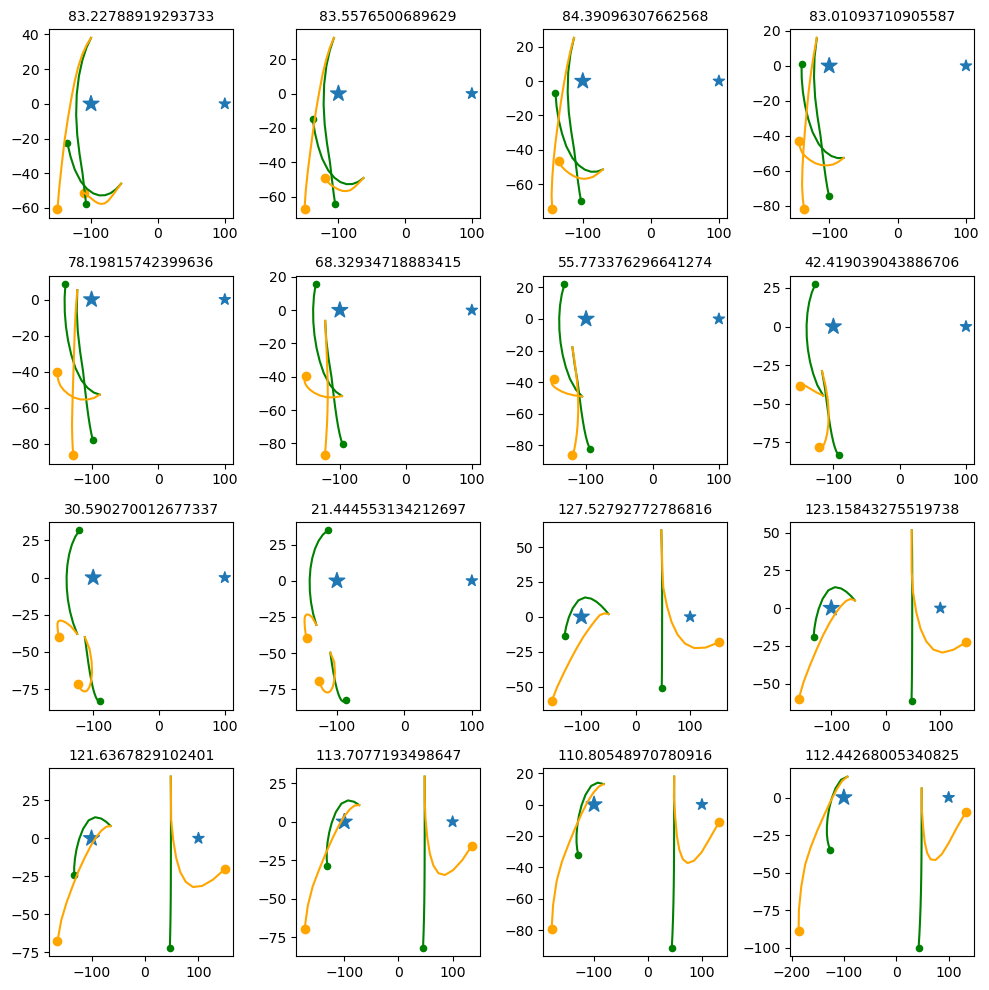

In [23]:
simulator = Simulator()
fig, axs = plt.subplots(4,4)
fig.set_size_inches(10, 10)
for row in range(4):
    for column in range(4):
        trial_num = 4*row+column
        simulator.reset([[valid_x[trial_num][particle_num*2], valid_x[trial_num][particle_num*2+1]] for particle_num in range(len(valid_x[0])//4)],
                        [[valid_x[trial_num][len(valid_x[0])//2+particle_num*2], valid_x[trial_num][len(valid_x[0])//2+particle_num*2+1]] for particle_num in range(len(valid_x[0])//4)],
                        init_test_locs, init_test_vs)
        simulator.run(10)
        simulator.plot_trajectories_subplots(axs[row, column])
        emulated_trajectory = emulate_run(valid_x[trial_num][:len(valid_x)//2], valid_x[trial_num][len(valid_x)//2:], 10)
        for charge_num in range(len(emulated_trajectory[0][0])//4):
            axs[row, column].plot([emulated_point[0][charge_num*2] for emulated_point in emulated_trajectory],
                     [emulated_point[0][charge_num*2+1] for emulated_point in emulated_trajectory],
                     color="orange")
            axs[row, column].scatter(emulated_trajectory[-1][0][charge_num*2], emulated_trajectory[-1][0][charge_num*2+1], c="orange")
        axs[row, column].set_title(quadrature_loss(emulated_trajectory[-1][0], valid_x[trial_num]).numpy(), fontsize=10)
plt.tight_layout()

### So these seem quite a bit worse.

Although the trajectories match up better than not, the quadrature losses show that it's less effective to emulate a simulation than to approximate the whole run in one go.

Why do *you* think this is?

As foreshadowed, I'll blame it on the architecture of the neural network.

Also, Mike thinks it could be because the step-by-step approach forms a meta-model that doesn't get fully backpropagated through. Good guess!

#### One last thing -- the Lyapunov exponent

Our trajectories always start out the same, and then diverge, partially because the neural network isn't a perfect copy of the simulation, and partially due to chaos -- small divergences from the simulated trajectory would lead to large divergences time, even if the emulation was 100% perfect from that point onward. The separation of the trajectories can be measured our quadtrature loss function, and tends to increase exponentially with time. The exponent of this relationship is named the Lyapunov exponent and characterizes the rate of divergence, and in some ways, the chaoticness of the system itself (plus the rate of error accumulation from the neural network approximation). Below I calculate the Lyapunov exponent for a single validation case.

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Raman\AppData\Local\Temp\ipykernel_179508\2463350133.py:27: RuntimeWarning: invalid value encountered in divide
  direction_vectors[i] = np.array([forcers_locs[i][0]-this_loc[0], forcers_locs[i][1]-this_loc[1]])/distances[i]
100%|██████████| 10/10 [00:00<00:00, 1880.01it/s]


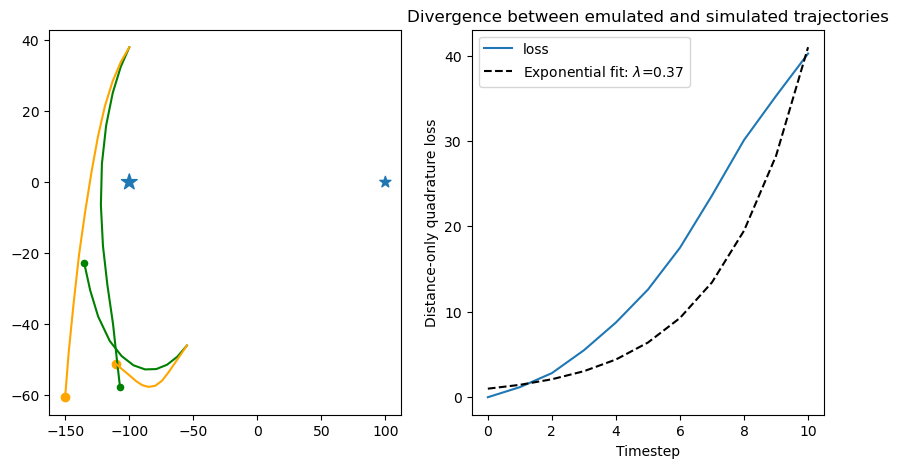

In [24]:
number_of_timesteps = 10
simulator.reset([[valid_x[0][particle_num*2], valid_x[0][particle_num*2+1]] for particle_num in range(len(valid_x[0])//4)],
                        [[valid_x[0][len(valid_x[0])//2+particle_num*2], valid_x[0][len(valid_x[0])//2+particle_num*2+1]] for particle_num in range(len(valid_x[0])//4)],
                        init_test_locs, init_test_vs)
simulator.run(number_of_timesteps)
simulated_trajectory = [np.ravel(t) for t in simulator.charge_trajectories]
simulated_v_trajectory = [np.ravel(t) for t in simulator.charge_v_trajectories]
simulated_trajectory = np.concatenate((simulated_trajectory, simulated_v_trajectory), axis=1)
emulated_trajectory = emulate_run(valid_x[0][:len(valid_x)//2], valid_x[0][len(valid_x)//2:], number_of_timesteps)
losses = []
for timestep in range(len(emulated_trajectory)):
    loss = quadrature_loss(emulated_trajectory[timestep][0], simulated_trajectory[timestep]).numpy()
    losses.append(loss)
fig, axs = plt.subplots(1,2, figsize=(10, 5))
simulator.plot_trajectories_subplots(axs[0])
for charge_num in range(len(emulated_trajectory[0][0])//4):
    axs[0].plot([emulated_point[0][charge_num*2] for emulated_point in emulated_trajectory],
             [emulated_point[0][charge_num*2+1] for emulated_point in emulated_trajectory],
             color="orange")
    axs[0].scatter(emulated_trajectory[-1][0][charge_num*2], emulated_trajectory[-1][0][charge_num*2+1], c="orange")
axs[1].plot(np.arange(len(losses)), losses, label="loss")
axs[1].set_title("Divergence between emulated and simulated trajectories")
axs[1].set_xlabel("Timestep")
axs[1].set_ylabel("Distance-only quadrature loss")
exponent = np.polyfit(np.arange(len(losses))[1:], np.log(losses[1:]), 1)[0]  # Avoid taking log of the 0th point, which is 0
axs[1].plot(np.arange(len(losses)), np.exp(exponent*np.arange(len(losses))), color="black", linestyle="--", label=f"Exponential fit: $\lambda$={exponent:.2f}")
axs[1].legend()